In [248]:
import pandas
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass, field
from pathlib import Path
import numpy
import seaborn
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

seaborn.set_style("whitegrid")

## Parsing and preparation

In [76]:
@dataclass(eq=True, order=True, frozen=True)
class Point:
    patient_id: str
    replica: str
    timepoint: str

@dataclass(eq=True, order=True, frozen=True)
class PointJoined:
    patient_id: str
    timepoint: str

In [77]:
data_path = Path("../data/")

In [116]:
data_tables = dict()
for file_path in data_path.iterdir():
    if file_path.match("BH_*ts_*_rep*.vcfsnpEff_genes.txt"):
        file_name = file_path.name
        point = Point(
            patient_id=file_path.name.split("_")[1][:-2],
            replica=file_path.name.split("_")[3].split(".")[0][3:],
            timepoint=file_path.name.split("_")[2]
        )
        # if point.patient_id == "1":
        #     continue
        data_tables[point] = pandas.read_csv(file_path, sep="\t", header=1)

In [117]:
joined_data_tables = dict()

for patient_id in ["1", "2", "3", "4"]:
    for timepoint in ["1", "2", "3", "4", "5"]:
        joined_point = PointJoined(patient_id=patient_id, timepoint=timepoint)
        data_frame_rep1 = data_tables[Point(patient_id=patient_id, timepoint=timepoint, replica="1")]
        data_frame_rep2 = data_tables[Point(patient_id=patient_id, timepoint=timepoint, replica="2")]
        joinsed_data_frame = pandas.concat([data_frame_rep1, data_frame_rep2])

        joined_data_tables[joined_point] = joinsed_data_frame

In [118]:
genes_set = set()
for point, data_frame in joined_data_tables.items():
    genes_set = genes_set.union(set(data_frame["GeneId"]))

In [119]:
vector_size = len(genes_set)
genes_to_idx = {g_name: idx for idx, g_name in enumerate(genes_set)}

In [120]:
vector_size

615

In [121]:
points = list()
ordered_patients_points = []
for point, data_frame in joined_data_tables.items():
    ordered_patients_points.append(point)
    gene_vector = numpy.zeros(vector_size)
    for gene_name, idx in genes_to_idx.items():
        gene_presence = numpy.sum(
            data_frame[
            data_frame["GeneId"] == gene_name
            ][
            ["variants_impact_HIGH", "variants_impact_MODERATE"]
            ].to_numpy()
        )
        if gene_presence:
            gene_vector[idx] = 1
    points.append(gene_vector)

In [122]:
points = numpy.array(points)

In [123]:
points.shape

(20, 615)

## Embeddings

In [153]:
epochs_number = 4000

In [154]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [155]:
masking_probabilities = numpy.random.normal(0.2, 0.01, epochs_number)
masking_probabilities[masking_probabilities < 0] = 0
masking_probabilities[masking_probabilities > 1] = 1
min(masking_probabilities), max(masking_probabilities)

(0.1588087941686374, 0.24135378122661338)

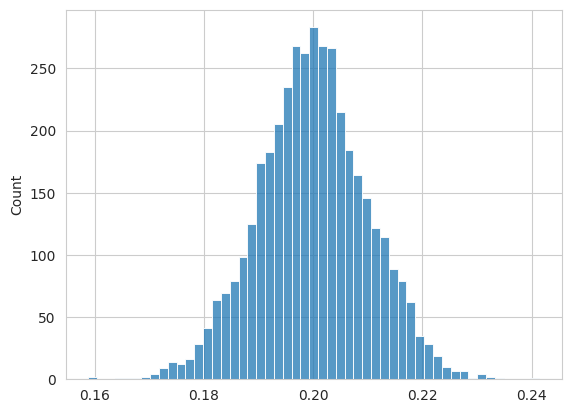

In [156]:
mask_prob_hist_figure = seaborn.histplot(masking_probabilities)

In [157]:
data = torch.from_numpy(points).float()

In [158]:
input_dim = data.shape[1]
hidden_dims = 128
embedding_dim = 8


model = Autoencoder(input_dim, hidden_dims, embedding_dim)
criterion = nn.MSELoss()


In [159]:
loss_values = []
optimizer = optim.Adam(model.parameters(), lr=0.003)
for epoch in range(epochs_number):
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{epochs_number}], Loss: {loss.item():.4f}")

    mask_prob = masking_probabilities[epoch]

    mask = torch.rand_like(data) > mask_prob
    masked_data = data * mask

    outputs = model(masked_data)
    loss = criterion(outputs, data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())


Epoch [100/4000], Loss: 0.0234
Epoch [200/4000], Loss: 0.0117
Epoch [300/4000], Loss: 0.0092
Epoch [400/4000], Loss: 0.0084
Epoch [500/4000], Loss: 0.0080
Epoch [600/4000], Loss: 0.0069
Epoch [700/4000], Loss: 0.0066
Epoch [800/4000], Loss: 0.0061
Epoch [900/4000], Loss: 0.0057
Epoch [1000/4000], Loss: 0.0052
Epoch [1100/4000], Loss: 0.0052
Epoch [1200/4000], Loss: 0.0049
Epoch [1300/4000], Loss: 0.0045
Epoch [1400/4000], Loss: 0.0045
Epoch [1500/4000], Loss: 0.0043
Epoch [1600/4000], Loss: 0.0043
Epoch [1700/4000], Loss: 0.0043
Epoch [1800/4000], Loss: 0.0043
Epoch [1900/4000], Loss: 0.0042
Epoch [2000/4000], Loss: 0.0042
Epoch [2100/4000], Loss: 0.0041
Epoch [2200/4000], Loss: 0.0042
Epoch [2300/4000], Loss: 0.0042
Epoch [2400/4000], Loss: 0.0040
Epoch [2500/4000], Loss: 0.0038
Epoch [2600/4000], Loss: 0.0038
Epoch [2700/4000], Loss: 0.0037
Epoch [2800/4000], Loss: 0.0037
Epoch [2900/4000], Loss: 0.0037
Epoch [3000/4000], Loss: 0.0037
Epoch [3100/4000], Loss: 0.0037
Epoch [3200/4000]

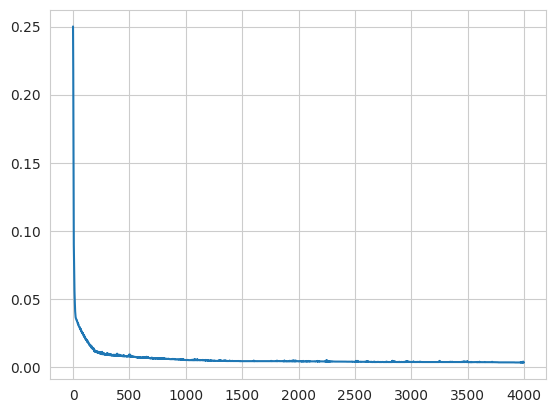

In [160]:
loss_plot = seaborn.lineplot(loss_values)

In [161]:
embeddings = model.encoder(data).detach().numpy()

In [162]:
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

In [163]:
components = pca.fit_transform(embeddings)

points_2d_dict = {
    "pca0": components.T[0],
    "pca1": components.T[1],
    "patient": [patient.patient_id for patient in ordered_patients_points],
    "timepoint": [patient.timepoint for patient in ordered_patients_points]
}

data_2d = pandas.DataFrame.from_dict(points_2d_dict)


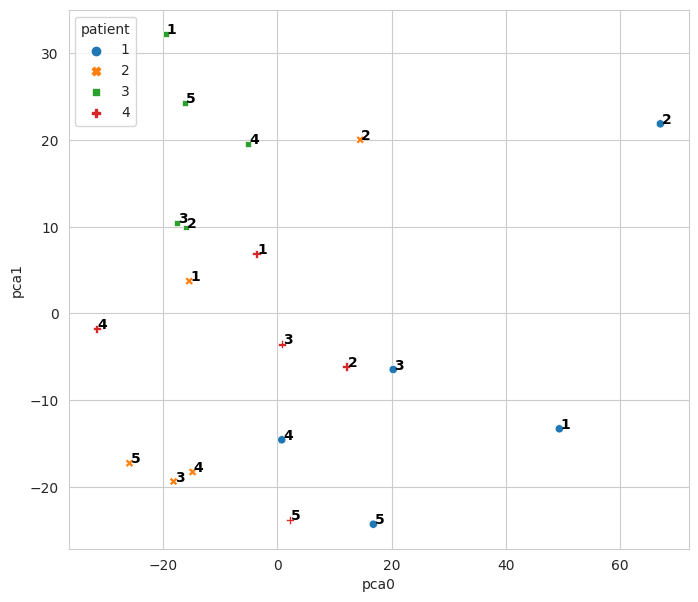

In [164]:
f, ax = plt.subplots(figsize=(8, 7))
fig = seaborn.scatterplot(data_2d, x="pca0", y="pca1", hue="patient", style="patient")

for line in range(0, data_2d.shape[0]):
     plt.text(
         data_2d.pca0[line]+0.2, 
         data_2d.pca1[line], 
         data_2d.timepoint[line], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         weight='semibold'
     )



## Flow calculation

In [165]:
mean_x_for_patient_for_timepoint = {}
mean_y_for_patient_for_timepoint = {}
for point in ordered_patients_points:
    patient_id, timepoint = point.patient_id, point.timepoint
    subdata = data_2d[numpy.logical_and(data_2d["patient"] == patient_id, data_2d["timepoint"] == timepoint)]
    x_mean = numpy.mean(subdata["pca0"])
    y_mean = numpy.mean(subdata["pca1"])
    mean_x_for_patient_for_timepoint[(patient_id, timepoint)] = x_mean
    mean_y_for_patient_for_timepoint[(patient_id, timepoint)] = y_mean

In [166]:
coord_x = []
coord_y = []
velocity_x = []
velocity_y = []
for idx, point in enumerate(ordered_patients_points):
    x, y = components[idx]
    v_x, v_y = 0, 0
    if (point.patient_id, str(int(point.timepoint) + 1)) in mean_x_for_patient_for_timepoint:
        v_x = mean_x_for_patient_for_timepoint[(point.patient_id, str(int(point.timepoint) + 1))] - x
        v_y = mean_y_for_patient_for_timepoint[(point.patient_id, str(int(point.timepoint) + 1))] - y
    coord_x.append(x)
    coord_y.append(y)
    velocity_x.append(v_x)
    velocity_y.append(v_y)
    

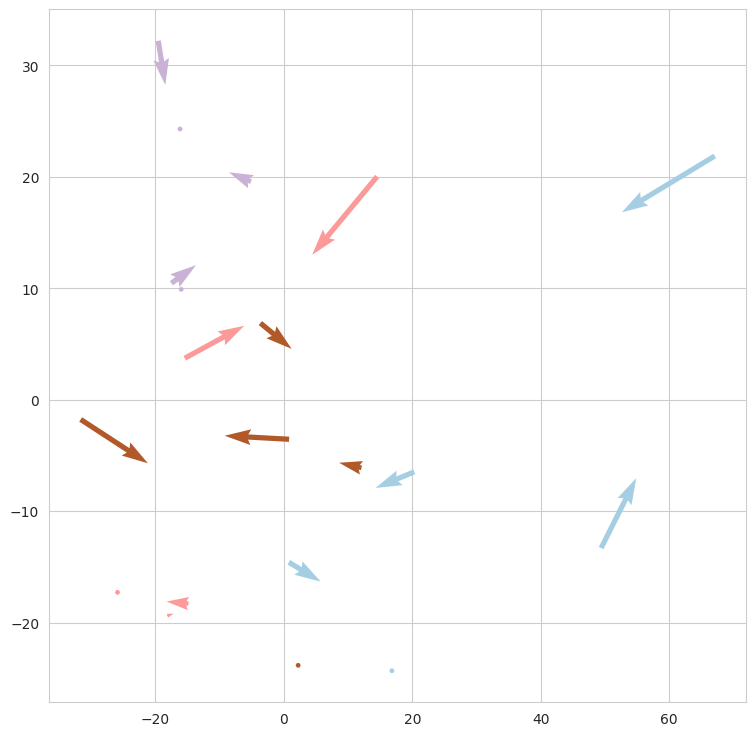

In [167]:
x = numpy.array(coord_x)
y = numpy.array(coord_y)
dx = numpy.array(velocity_x)
dy = numpy.array(velocity_y)

plt.rcParams['image.cmap'] = 'Paired'

fig, ax = plt.subplots(figsize =(9, 9))

ax.quiver(
    x, 
    y, 
    dx, 
    dy, 
    [int(patient.patient_id) for patient in ordered_patients_points], 
    units='width'
)


plt.show()

## Points bootstrap

In [229]:
n = 200
bootstrapped_data = []
for mask_prob in masking_probabilities[:n]:
    mask = torch.rand_like(data) > mask_prob * 3
    bootstrapped_data.append(data * mask)


In [230]:
bootstrapped_embeddings = model.encoder(torch.cat(bootstrapped_data, 0)).detach().numpy()

In [231]:
pca = PCA(n_components=2)
pca.fit(bootstrapped_embeddings)

PCA(n_components=2)

In [232]:
bootstrapped_components = pca.fit_transform(bootstrapped_embeddings)

bootstrapped_points_2d_dict = {
    "pca0": bootstrapped_components.T[0],
    "pca1": bootstrapped_components.T[1],
    "patient": [patient.patient_id for patient in ordered_patients_points] * n,
    "timepoint": [patient.timepoint for patient in ordered_patients_points] * n
}

bootstrapped_data_2d = pandas.DataFrame.from_dict(bootstrapped_points_2d_dict)


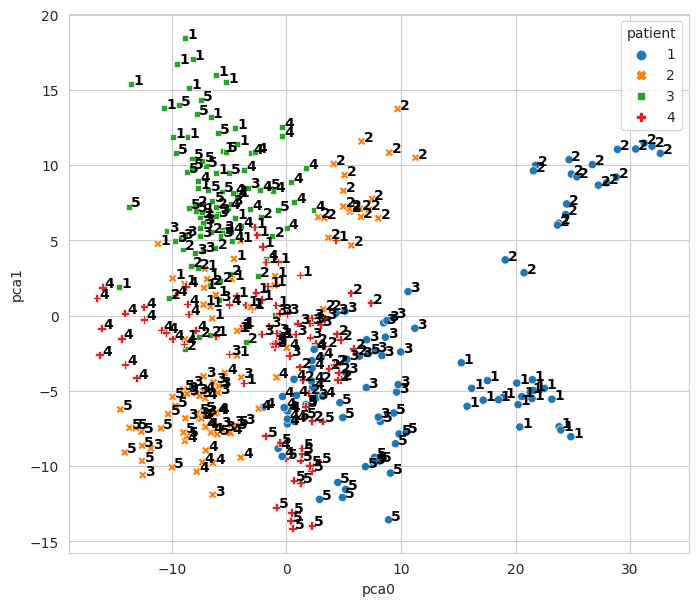

In [228]:
f, ax = plt.subplots(figsize=(8, 7))
fig = seaborn.scatterplot(bootstrapped_data_2d, x="pca0", y="pca1", hue="patient", style="patient")

for line in range(0, bootstrapped_data_2d.shape[0]):
     plt.text(
         bootstrapped_data_2d.pca0[line]+0.2, 
         bootstrapped_data_2d.pca1[line], 
         bootstrapped_data_2d.timepoint[line], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         weight='semibold'
     )

## Bootstraped flow

In [287]:
def draw_flow():
    mean_x_for_patient_for_timepoint = {}
    mean_y_for_patient_for_timepoint = {}
    for point in ordered_patients_points:
        patient_id, timepoint = point.patient_id, point.timepoint
        subdata = bootstrapped_data_2d[numpy.logical_and(
            bootstrapped_data_2d["patient"] == patient_id, 
            bootstrapped_data_2d["timepoint"] == timepoint
        )]
        x_mean = numpy.mean(subdata["pca0"])
        y_mean = numpy.mean(subdata["pca1"])
        mean_x_for_patient_for_timepoint[(patient_id, timepoint)] = x_mean
        mean_y_for_patient_for_timepoint[(patient_id, timepoint)] = y_mean
    
    coord_x = []
    coord_y = []
    velocity_x = []
    velocity_y = []
    for idx, point in enumerate(ordered_patients_points * n):
        x, y = bootstrapped_components[idx]
        v_x, v_y = 0, 0
        if (point.patient_id, str(int(point.timepoint) + 1)) in mean_x_for_patient_for_timepoint:
            v_x = mean_x_for_patient_for_timepoint[(point.patient_id, str(int(point.timepoint) + 1))] - x
            v_y = mean_y_for_patient_for_timepoint[(point.patient_id, str(int(point.timepoint) + 1))] - y
        coord_x.append(x)
        coord_y.append(y)
        velocity_x.append(v_x)
        velocity_y.append(v_y)

    x = numpy.array(coord_x)
    y = numpy.array(coord_y)
    dx = numpy.array(velocity_x)
    dy = numpy.array(velocity_y)
    
    plt.rcParams['image.cmap'] = 'tab10'
    
    fig, ax = plt.subplots(figsize =(10, 10))

    qv1 = ax.quiver(
        x, 
        y, 
        dx * 2, 
        dy * 2, 
        [int(patient.patient_id) for patient in ordered_patients_points] * n, 
        units='width'
    )
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    handles = []
    for idx, manual_lable in enumerate(["1", "2", "3", "4"]):
        handles.append(mpatches.Patch(color=matplotlib.colormaps['tab10'](idx * 3), label=manual_lable))

    plt.legend(handles=handles, loc="upper center", ncol=4, title="Patients")

    plt.savefig("../results/patients_dynamic.pdf", bbox_inches = 'tight')
    plt.show()

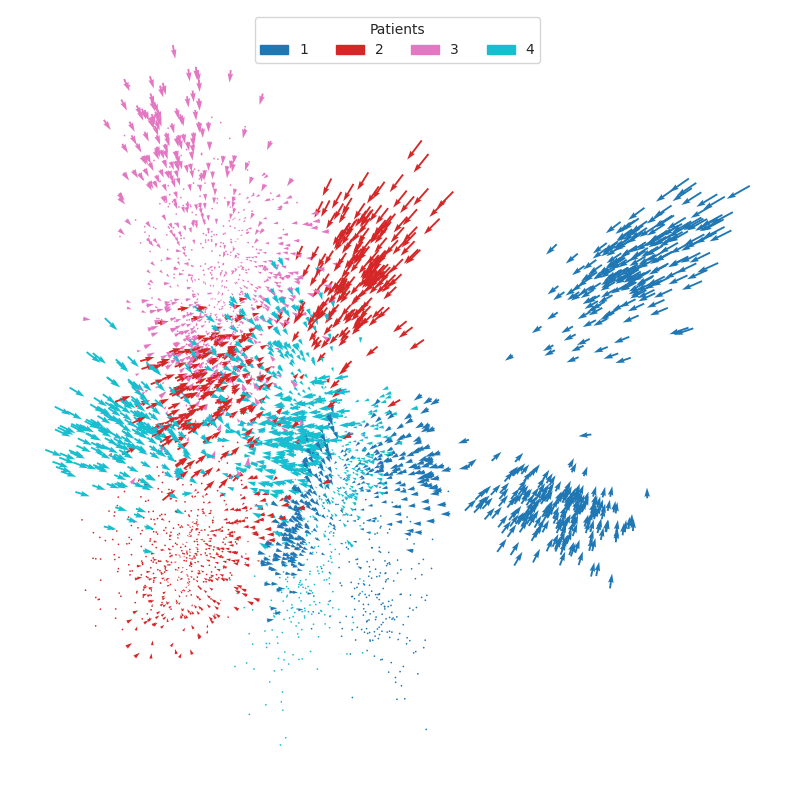

In [288]:
draw_flow()